In [93]:
import pandas as pd
import numpy as np
from girth import twopl_jml, ability_mle, ability_map
import sys
from tqdm import tqdm
from matplotlib import pyplot as plt
sys.path.append("..")
from dirt import irf


In [5]:
def construct_lsat7_dataset(path_to_csv: str = "/home/daavid/lsat7.csv") -> pd.DataFrame:
    lsat7 = pd.read_csv(path_to_csv)
    lsat7 = lsat7.drop(columns="Unnamed: 0")
    lsat7 = lsat7.rename(columns={col:col.replace(".","_") for col in lsat7.columns})
    lsat7.index.repeat(lsat7.freq)
    expanded = pd.DataFrame(np.repeat(lsat7.values, lsat7.freq, axis=0),columns=lsat7.columns).drop(columns="freq")
    return expanded
    

According to Lord 1984, the SEm is
$$SEm(\theta_0) =\sqrt{\sum^n_{i=1} P(x = 1 | \theta = \theta_0)\cdot (1-P(x = 1 | \theta = \theta_0))}$$
This standard error of measurement is expressed in units of # of questions correct, rather than scaled score points.

Note that when X and Y are independent random variables, 
$$Var[X+Y] = Var[X] + Var[Y]$$
And that the variance of a bernoulli random variable is $P(x)(1-P(x))$.

So the quantity inside the square root is intutively the total variance of the test at $\theta = \theta_0$



This standard error of measurement is expressed in units of # of questions correct, rather than scaled score points.

Let's compute the SEm for each student in the Bock & Lieberman Dataset:

In [17]:
pd.DataFrame(params)

,Discrimination,Difficulty
0,0.80286,-1.202129
1,4.00000,0.368345
2,4.00000,0.058751
3,0.25000,1.380074
4,0.25000,-4.902024


In [37]:
item_params = pd.DataFrame(params)
for idx,(disc,diff) in item_params.iterrows():
    print(disc, diff)

0.802859605912795 -1.202128517766773
4.0 0.36834539184967885
3.9999999999995577 0.058750768050051125
0.25000000000599 1.3800737632304878
0.2500000000056114 -4.9020235483091446


In [11]:
lsat7 = construct_lsat7_dataset()
params = twopl_jml(lsat7.transpose())
abilities = ability_map(dataset=lsat7.transpose().to_numpy(), difficulty = params["Difficulty"], discrimination=params["Discrimination"])


In [44]:
def sem_from_ability(ability: float, item_params: pd.DataFrame) -> float:
    """Given an ability score, compute the standard error of measurement at that ability using the IRT method given in Frederic M. Lord's 1984 paper
    Args: 
       ability: theta from the irt model
       item_params: a dataframe with columns called "Discrimination" and "Difficulty" containing the fitted item parameters
    """
    variances = list()
    assert list(item_params.columns) == ["Discrimination", "Difficulty"]
    for idx,(disc,diff) in item_params.iterrows():
        prob_success = irf(ability=ability, disc =disc, diff= diff)
        variance = prob_success*(1-prob_success)
        variances.append(variance)
    return np.sqrt(np.sum(variances))


In [45]:
sem_from_ability(ability=0, item_params=item_params)

1.0080522888821313

In [52]:
sems = [sem_from_ability(theta,item_params) for theta in abilities]

In [55]:
overall_sem = np.mean(sems)
overall_sem

0.9011392149224411

Note that we could probably give us a better estimate by taking a weighted average, where the weights are determined by the frequencies of the response vectors in the original 32 row Bock & Liebrerman dataset. However, as we'll see shortly this estimate is pretty good as is.

(array([308., 200.,  32.,  78.,  65.,   7.,   0.,   0.,   0., 310.]),
 array([0.81721405, 0.83823124, 0.85924843, 0.88026563, 0.90128282,
        0.92230001, 0.9433172 , 0.96433439, 0.98535158, 1.00636878,
        1.02738597]),
 <BarContainer object of 10 artists>)

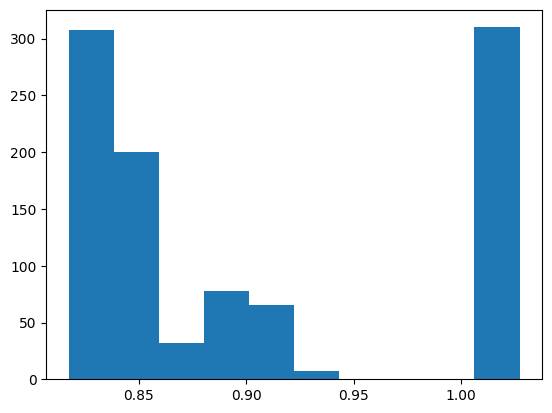

In [57]:
plt.hist(sems)

In [58]:
unique_abilities = set(abilities)

In [60]:
unique_sems = [sem_from_ability(th,item_params) for th in unique_abilities]

In [65]:
len(unique_abilities)

32

In [66]:
len(unique_sems)

32

Text(0, 0.5, 'SEm(Theta)')

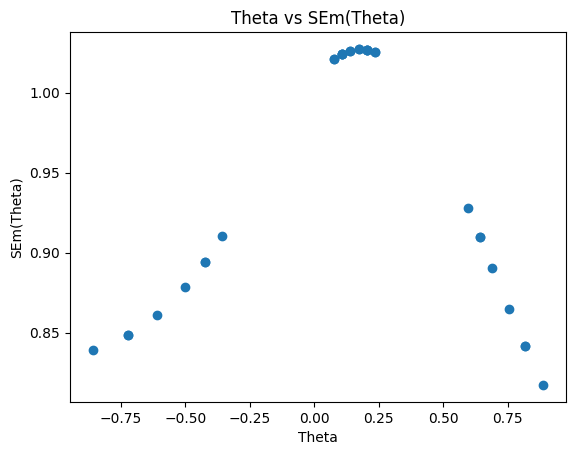

In [69]:
plt.scatter(x=list(unique_abilities),y=unique_sems)
plt.title("Theta vs SEm(Theta)")
plt.xlabel("Theta")
plt.ylabel("SEm(Theta)")

Notice that the error is smaller at the tails. This makes intuitive sense - if your true ability is way off the scale on the left, you are never going to answer a question right, because your true ability is much lower than the test is designed to measure. On the other hand if you are far off the scale to the right, you are very unlikely to ever answer a question incorrectly, since the test is far too easy for you. In both cases the variance of your observed scores will be small.

However, it's probably _not_ what we _want_. Since most of the test-takers will not have their ability in the tails, we want to optimize the questions so that the SEm is lower for students in the middle of the distribution

<Axes: xlabel='Difficulty', ylabel='Discrimination'>

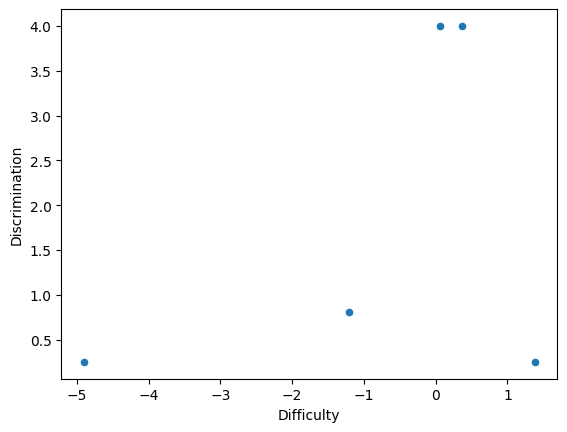

In [124]:
item_params.sort_values("Difficulty").plot.scatter(x="Difficulty", y="Discrimination")

Let's verify the IRT method of computing SEm by constructing the standard error of the number of correct questions by using the bootstrap. We just constuct the bootstrap sampling distribution and then take the standard deviation

In [71]:
np.random.choice(range(100),size=10)

array([75, 15, 42, 61, 69, 70, 89,  3, 29, 13])

In [72]:
lsat7

,Item_1,Item_2,Item_3,Item_4,Item_5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,1,1,1,1,1
996,1,1,1,1,1
997,1,1,1,1,1
998,1,1,1,1,1


In [92]:
unique_responses = list(map(list,lsat7.drop_duplicates().to_numpy()))

In [94]:
SEm_theta_from_bootstrap = list()
for student_resp in tqdm(unique_responses, "response vector"):
    sample_n_correct = [sum(np.random.choice(student_resp,size=5,replace=True)) for _ in range(100_000)]
    SEm_theta = np.std(sample_n_correct)
    SEm_theta_from_bootstrap.append(SEm_theta)
    
    

response vector: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:51<00:00,  1.61s/it]


The mean $SEm(\theta)$ we got from bootstrapping is pretty close to the one we got from the IRT method:

In [96]:
np.mean(SEm_theta_from_bootstrap)

0.9645632059792053

The definition of SEm that we used from Lord's 1984 paper has  since been superseded by a quantity called the Standard Error of the Estimate  ( $SE_{est} $).

To define $SE_{est}$, we first need to define two other quantities, the item information function and the test information function.
The item information function for a 2PL model is:
$$I(\theta) = D^2 a^2 P(\theta)(1-P(\theta)) $$

where D is a scaling factor of 1.70, $a$ is the discrimination. and $P(\theta)$ is the probability obtained from the item response function.

We can now define the test information funtion as the sum of all the item information:



where $${\text{TI}}(\theta) := \sum_{i=1}^n I_i(\theta) $$

Finally, $$SE_{est} = \frac{1}{\sqrt{(TI(\theta)}}$$

In [143]:
def iic(ability, diff, disc,scale=True):
    """Item Information Function"""
    D = 1.70
    prob = irf(ability=ability, diff=diff,disc=disc)
    info = (disc**2)*prob*(1-prob)
    if scale:
        info = (D**2)*info
    return info
    

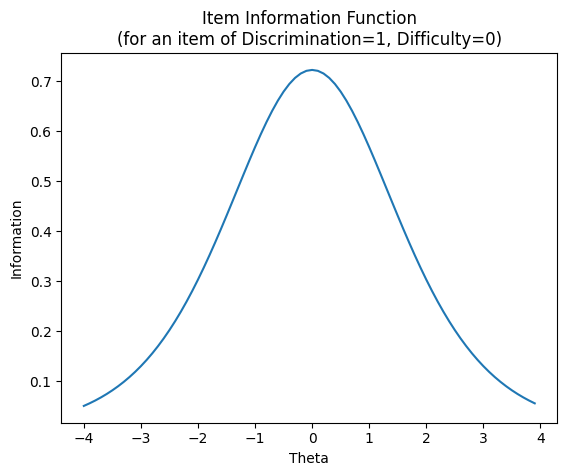

In [169]:
x = np.arange(-4,4,0.1)
fig, ax = plt.subplots()
y =iic(ability=x,disc=1,diff=0)
ax.plot(x,y)
plt.title("Item Information Function\n(for an item of Discrimination=1, Difficulty=0)")
# ax.legend(title="Item Information")
plt.xlabel("Theta")
plt.ylabel("Information")
plt.savefig("iif.png")

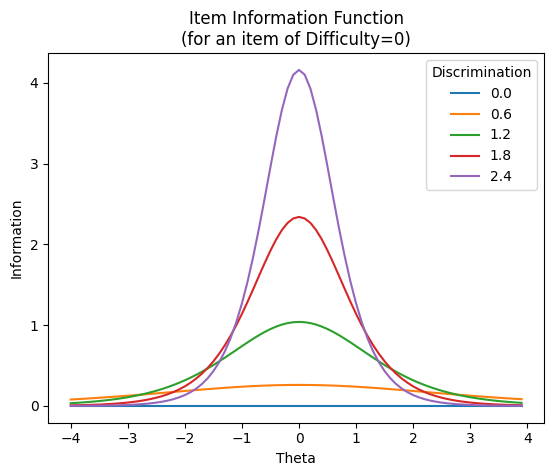

In [178]:
x = np.arange(-4,4,0.1)
disc =np.arange(0,3,0.6)
fig, ax = plt.subplots()
for disc in np.arange(0,3,0.6):
    y =iic(ability=x,disc=disc,diff=0)
    ax.plot(x,y,label=round(disc,2))
    plt.title("Item Information Function\n(for an item of Difficulty=0)")
    ax.legend(title="Discrimination")
    plt.xlabel("Theta")
    plt.ylabel("Information")
    plt.savefig("iif.png")

In [151]:
def test_information(ability, item_parameters):
    """For a given ability, add up the item information for every item"""
    return iic(ability=ability,disc=item_params["Discrimination"],diff=item_params["Difficulty"]).sum()

In [157]:
def se_est(ability, item_parameters):
    return 1/np.sqrt(test_information(ability,item_parameters))

In [158]:
se_est(0,item_parameters=item_params)

0.23024810207820026

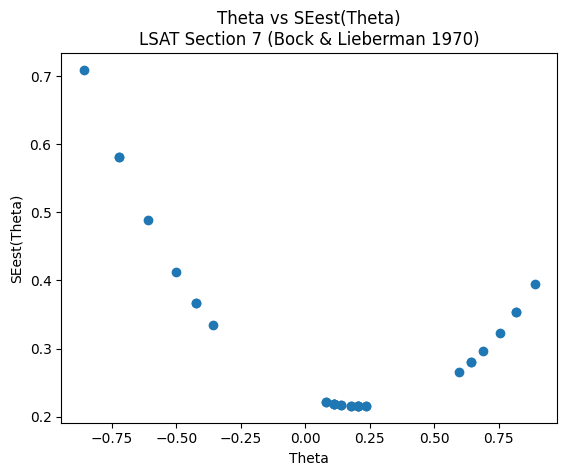

In [163]:
unique_se_est = [se_est(th,item_params) for th in unique_abilities]
plt.scatter(x=list(unique_abilities),y=unique_se_est)
plt.title("Theta vs SEest(Theta)\nLSAT Section 7 (Bock & Lieberman 1970)")
plt.xlabel("Theta")
plt.ylabel("SEest(Theta)")
plt.savefig("se_est_lsat7.png")